# Exploring images

* Min values $> 0$ in both modalities $\Rightarrow$ `voxelArrayShift`$=0$.
* Detecting outliers?

**Selecting bin sizes**: [Checkout](https://www.statisticshowto.datasciencecentral.com/choose-bin-sizes-statistics/)

In [1]:
import sys
sys.path.append('../src')

import nrrd
import ioutil

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Inter quartile range
from scipy.stats import iqr

%matplotlib inline

In [2]:
np.set_printoptions(precision=2)

In [3]:
ct_paths = ioutil.relative_paths(
    './../../data/images/ct_cropped/', target_format='nrrd'
)
pet_paths = ioutil.relative_paths(
    './../../data/images/pet_cropped', target_format='nrrd'
)
masks_paths = ioutil.relative_paths(
    './../../data/images/masks_cropped/', target_format='nrrd'
)

In [4]:
def bin_width(sigma, n):
    
    return 3.49 * sigma * n ** (-1 / 3)

In [5]:
def cropped_image_info(path_images, path_masks):
    
    image_data, metadata, num = [], [], []
    for image_path, mask_path in zip(path_images, path_masks):
        
        # NB: 
        raw_image_data, header = nrrd.read(image_path)
        mask, _ = nrrd.read(mask_path)
        data = raw_image_data * mask
        
        header['min'] = np.min(data)
        header['max'] = np.max(data)
        header['num_unique'] = np.unique(data).size
        header['std'] = np.std(data)
        header['iqr'] = iqr(data)
        header['samples'] = data.shape[-1]

        num.append(ioutil.sample_num(image_path))
        image_data.append(data), metadata.append(header)
        
    return dict(zip(*(num, image_data))), pd.DataFrame(metadata, index=num)

## External CT Statistics

Per patient

In [6]:
ct_data, ct_mdata = cropped_image_info(ct_paths, masks_paths)
ct_mdata.head()

,type,dimension,sizes,endian,encoding,min,max,num_unique,std,iqr,samples
2,double,3,"[82, 83, 68]",little,gzip,0.0,1450.980316,2459,205.383480,0.0,68
4,double,3,"[69, 64, 74]",little,gzip,0.0,1414.363699,4280,184.759833,0.0,74
5,double,3,"[73, 70, 82]",little,gzip,0.0,1763.283818,4641,213.666088,0.0,82
8,double,3,"[81, 106, 114]",little,gzip,0.0,1534.148775,4945,271.031115,0.0,114
10,double,3,"[72, 72, 72]",little,gzip,0.0,1364.937514,1907,179.669827,0.0,72


Averaged

In [7]:
ct_mdata.max()

type           double
dimension           3
endian         little
encoding         gzip
min                 0
max           4094.94
num_unique      28080
std           425.364
iqr                 0
samples           142
dtype: object

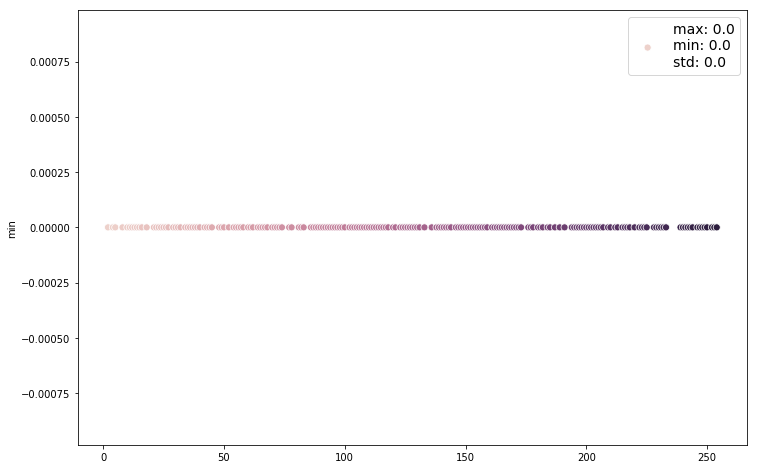

In [8]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=ct_mdata.index, y='min', data=ct_mdata, hue=ct_mdata.index, s=50
);
plt.legend(
    [
            'max: {}\nmin: {}\nstd: {}'.format(
                np.max(ct_mdata['min']),
                np.min(ct_mdata['min']),
                np.std(ct_mdata['min'])
            )
    ], loc='best', fontsize=14
);

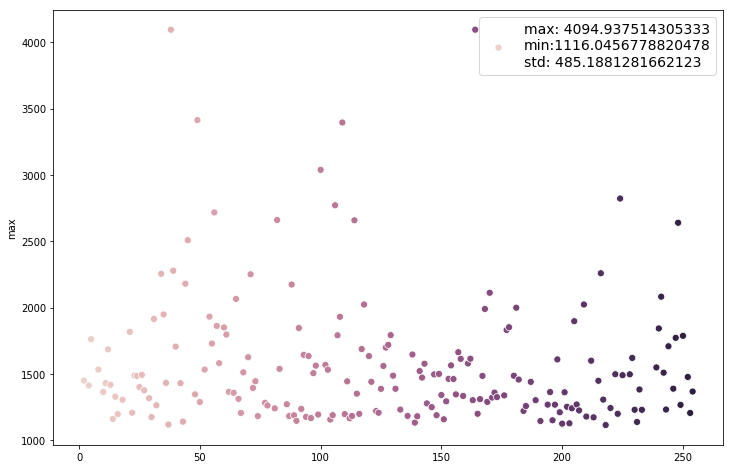

In [9]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=ct_mdata.index, y='max', data=ct_mdata, hue=ct_mdata.index, s=50
);
plt.legend(
    [
            'max: {}\nmin:{}\nstd: {}'.format(
                np.max(ct_mdata['max']), 
                np.min(ct_mdata['max']),
                np.std(ct_mdata['max'])
            )
    ], loc='best', fontsize=14
);

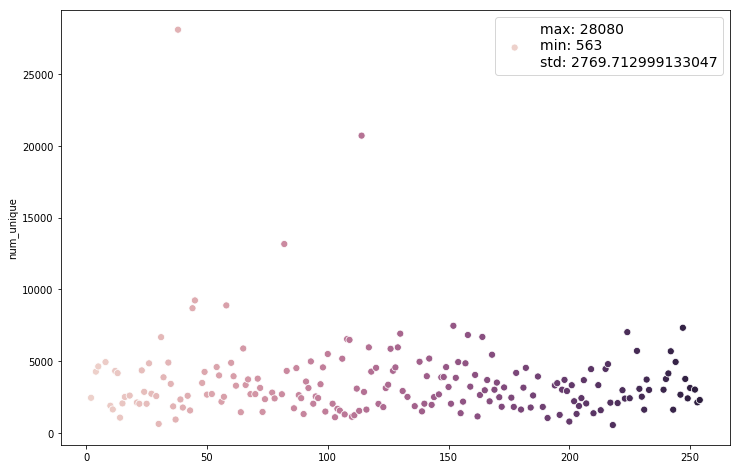

In [10]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=ct_mdata.index, y='num_unique', data=ct_mdata, hue=ct_mdata.index, s=50
);
plt.legend(
    [
        'max: {}\nmin: {}\nstd: {}'.format(
            np.max(ct_mdata.num_unique), 
            np.min(ct_mdata.num_unique),
            np.std(ct_mdata.num_unique)
        )
    ], loc='best', fontsize=14
);

### Fixed bin width
Determine the fixed bin widths based on average number of unique intensity values across scans.

In [11]:
avg_ct_range = ct_mdata.mean()['max'] - ct_mdata.mean()['min']
print('Average range: {}'.format(avg_ct_range))

Average range: 1563.9207535082262


Binned widths: [52.13 24.69 16.18 12.03]


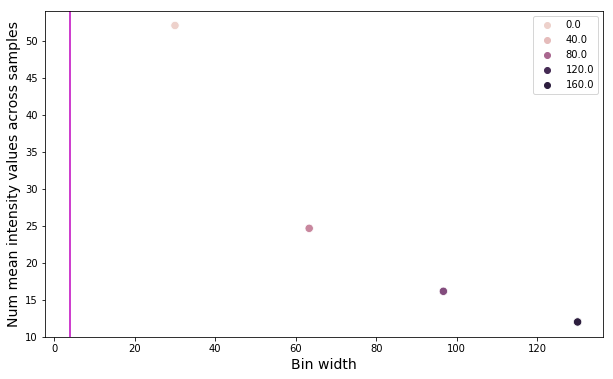

In [12]:
nbins = 4
# NOTE: According to pyradiomics recommendations, te optimal number of 
# bins ranges from 30 to 130.
bin_widths = np.linspace(30, 130, nbins)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=bin_widths, y=avg_ct_range / bin_widths, hue=bin_widths, 
    s=70
);
plt.xlabel('Bin width', fontsize=14), 
plt.ylabel('Num mean intensity values across samples', fontsize=14);
plt.axvline(x=nbins, c='m');
print('Binned widths: {}'.format(avg_ct_range / bin_widths))

In [13]:
print('Binned widths: {}'.format(avg_ct_range / 512))

Binned widths: 3.0545327216957543


**NOTE**:
* All IQR are zero. Having an IQR of 0 means there is no variability in the middle 50$\%$ of your data, but the center of the distribution can be anywhere. Thus, cannot apply Freedman-Diaconis’s Rule for bin width.
* In any normal distribution with mean $\mu$ and standard deviation $\sigma$: 
    * Approximately 68$\%$  of the data fall within one standard deviation of the mean.
    * Approximately 95$\%$ of the data fall within two standard deviations of the mean.
    * Approximately 99.7$\%$ of the data fall within three standard deviations of the mean.


/Users/severinlangberg/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


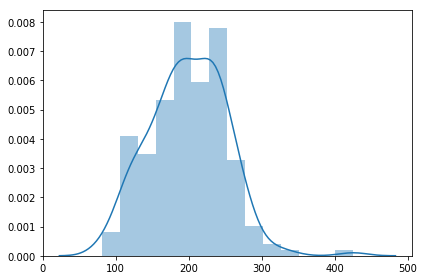

In [14]:
plt.figure()
# NOTE: Determines num bins with F-D rule.
sns.distplot(ct_mdata['std'].values)
plt.tight_layout()

In [15]:
selected_std = [
    ct_mdata['std'].min(), 
    ct_mdata['std'].min() + ct_mdata['std'].std(),
    ct_mdata['std'].min() + 2 * ct_mdata['std'].std(),
    ct_mdata['std'].min() + 3 * ct_mdata['std'].std(),
    ct_mdata['std'].max()
]
selected_std

[80.86358678488313,
 133.2820693079489,
 185.70055183101465,
 238.11903435408044,
 425.3635505029845]

In [16]:
#selected_bin_widhts = [
#    bin_widht(sigma, num), for sigma, num in zip(selected_std, sample_nums)
#]
#selected_bin_widhts
glob_ct_bin_width = bin_width(ct_mdata['std'].mean(), ct_mdata['std'].size)
glob_ct_bin_width

119.20031372325734

## External PET Statistics

Compare statistics between patients.

In [14]:
pet_data, pet_mdata = cropped_image_info(pet_paths, masks_paths)
pet_mdata.head()

,type,dimension,sizes,endian,encoding,min,max,num_unique,std,iqr,samples
2,double,3,"[82, 83, 68]",little,gzip,0.0,24.741200,14636,2.320645,0.0,68
4,double,3,"[69, 64, 74]",little,gzip,0.0,18.655424,8278,1.386705,0.0,74
5,double,3,"[73, 70, 82]",little,gzip,0.0,16.739500,14048,1.631462,0.0,82
8,double,3,"[81, 106, 114]",little,gzip,0.0,14.210913,30803,1.419874,0.0,114
10,double,3,"[72, 72, 72]",little,gzip,0.0,8.792835,8599,0.748462,0.0,72


Average

In [15]:
pet_mdata.mean(axis=0)

dimension         3.000000
min               0.000000
max              13.175777
num_unique    15005.595960
std               1.245377
iqr               0.000000
samples          83.237374
dtype: float64

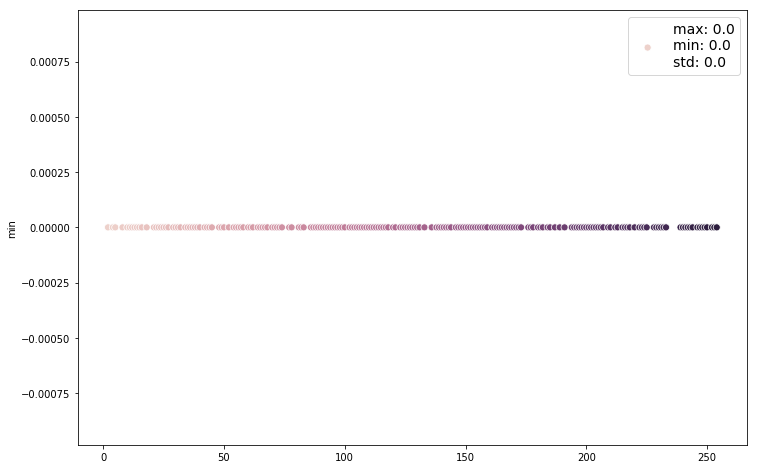

In [16]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=pet_mdata.index, y='min', data=pet_mdata, hue=pet_mdata.index, s=50
);
plt.legend(
    [
            'max: {}\nmin: {}\nstd: {}'.format(
                np.max(pet_mdata['min']), 
                np.min(pet_mdata['min']),
                np.std(pet_mdata['min'])
            )
    ], loc='best', fontsize=14
);

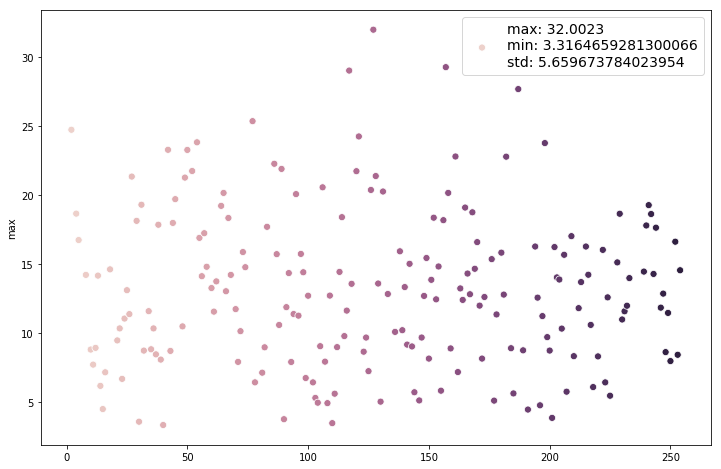

In [17]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=pet_mdata.index, y='max', data=pet_mdata, hue=pet_mdata.index, s=50
);
plt.legend(
    [
            'max: {}\nmin: {}\nstd: {}'.format(
                np.max(pet_mdata['max']), 
                np.min(pet_mdata['max']),
                np.std(pet_mdata['max'])
            )
    ], loc='best', fontsize=14
);

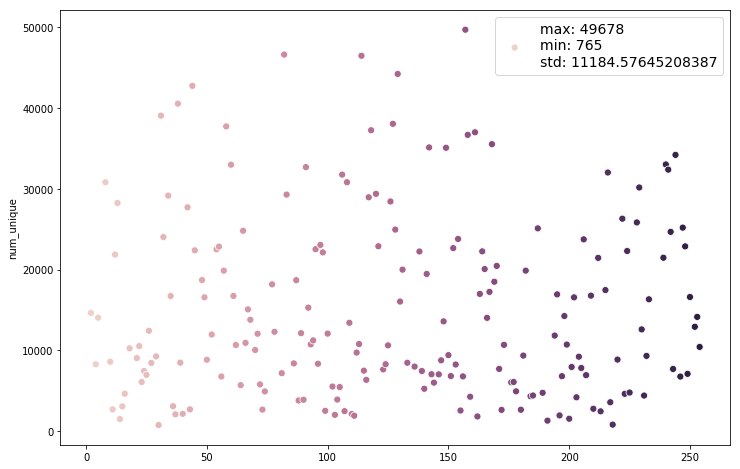

In [18]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=pet_mdata.index, y='num_unique', data=pet_mdata, hue=pet_mdata.index, s=50
);
plt.legend(
    [
        'max: {}\nmin: {}\nstd: {}'.format(
            np.max(pet_mdata.num_unique), 
            np.min(pet_mdata.num_unique),
            np.std(pet_mdata.num_unique)
        )
    ], loc='best', fontsize=14
);

### Fixed bin width

In [19]:
avg_pet_range = pet_mdata.mean()['max'] - pet_mdata.mean()['min']
print('Average range: {}'.format(avg_pet_range))

Average range: 13.175776940151492


Binned widths: [0.44 0.21 0.14 0.1 ]


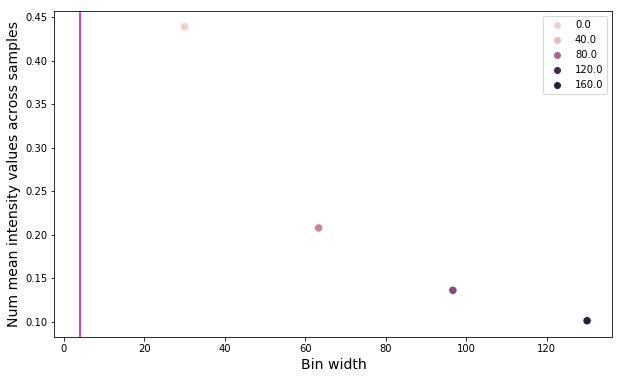

In [20]:
nbins = 4
# NOTE: According to pyradiomics recommendations, te optimal number of 
# bins ranges from 30 to 130.
bin_widths = np.linspace(30, 130, nbins)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=bin_widths, y=avg_pet_range/bin_widths, hue=bin_widths, 
    s=70
);
plt.xlabel('Bin width', fontsize=14), 
plt.ylabel('Num mean intensity values across samples', fontsize=14);
plt.axvline(x=nbins, c='m');
print('Binned widths: {}'.format(avg_pet_range / bin_widths))

In [21]:
print('Binned widths: {}'.format(avg_pet_range / 256))

Binned widths: 0.051467878672466764


In [22]:
glob_pet_bin_width = bin_width(pet_mdata['std'].mean(), pet_mdata['std'].size)
glob_pet_bin_width

0.7457120395644998